# Data Science Template 

## Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
path = './'
file_train = 'train_ZoGVYWq.csv'
file_test = 'test_66516Ee.csv'
df_train_pre = pd.read_csv(path+file_train)
df_test_pre = pd.read_csv(path+file_test)

## Analysing NaN's

In [174]:
df_train_pre.isnull().sum(axis=0) / df_train_pre.shape[0] * 100

id                                  0.000000
perc_premium_paid_by_cash_credit    0.000000
age_in_days                         0.000000
Income                              0.000000
Count_3-6_months_late               0.121473
Count_6-12_months_late              0.121473
Count_more_than_12_months_late      0.121473
application_underwriting_score      3.724343
no_of_premiums_paid                 0.000000
sourcing_channel                    0.000000
residence_area_type                 0.000000
premium                             0.000000
renewal                             0.000000
dtype: float64

## Preprocessing

In [8]:
from sklearn.preprocessing import Imputer
from sklearn_pandas import DataFrameMapper, gen_features, CategoricalImputer

In [5]:
#selecting columns of different types
target = 'renewal'
y = df_train_pre[target]
col_object = df_train_pre.select_dtypes('O')
col_num = df_train_pre.drop(target,axis=1).select_dtypes(['int64','float64'])
col_dates = df_train_pre.select_dtypes(['datetime64','timedelta64'])

In [132]:
def fill_na(df,col_object,col_num,col_dates):
    imp_obj = gen_features(
            columns=[[x] for x in col_object],
            classes=[CategoricalImputer()]
        )

    imp_num = gen_features(            
        columns=[[x] for x in col_num],
        classes=[{'class': Imputer, 'strategy': 'median'}]
    )
    
    na_mapper = DataFrameMapper(imp_obj+imp_num,df_out=True)
    
    return na_mapper, na_mapper.fit_transform(df)

In [133]:
na_mapper,df_train = fill_na(df_train_pre,col_object,col_num,col_dates)
_ , df_test = fill_na(df_test_pre,col_object,col_num,col_dates)

## Check covariance shift

In [58]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score

In [92]:
df_all = df_train.drop('id',axis=1).copy()
df_all['DatasetID'] = 0
df_all = pd.concat(
    [df_all,df_test.drop('id',axis=1)]
    ,axis=0
    ,sort=True
)
df_all.fillna(1,inplace=True)
df_all.reset_index(drop=True,inplace=True)

In [95]:
Xtrain,Xtest,ytrain,ytest = train_test_split(df_all.drop('DatasetID',axis=1),df_all['DatasetID'],test_size=0.3,shuffle=True)
dct_res = {'col': [], 'roc_auc_cv': [], 'roc_auc_test': []}
m = RandomForestClassifier(n_estimators = 50, max_depth = 5,min_samples_leaf = 5,random_state=2018)
for c in Xtrain.columns:
    le = LabelEncoder()
    lm = MinMaxScaler()
    dtrain = Xtrain[c].values.reshape(-1,1)
    dtest = Xtest[c].values.reshape(-1,1)
    if Xtrain[c].dtype=='object':
        dtrain = le.fit_transform(dtrain.ravel()).reshape(-1,1)
        dtest = le.transform(dtest.ravel()).reshape(-1,1)
#     dtrain = lm.fit_transform(dtrain).reshape(-1,1)
#     dtest = lm.transform(dtest).reshape(-1,1)
    dct_res['col'].append(c)
    dct_res['roc_auc_cv'].append(np.mean(cross_val_score(m,dtrain,ytrain,cv=5,scoring='roc_auc')))
    m.fit(dtrain,ytrain)
    dct_res['roc_auc_test'].append(roc_auc_score(ytest,m.predict_proba(dtest)[:,0]))
coshift = pd.DataFrame.from_dict(dct_res)

In [96]:
coshift

,col,roc_auc_cv,roc_auc_test
0,Count_3-6_months_late,0.501038,0.502038
1,Count_6-12_months_late,0.500272,0.500250
2,Count_more_than_12_months_late,0.500189,0.499915
3,Income,0.501296,0.502013
4,age_in_days,0.501813,0.496966
5,application_underwriting_score,0.500435,0.501161
6,no_of_premiums_paid,0.501815,0.506280
7,perc_premium_paid_by_cash_credit,0.501578,0.502998
8,premium,0.497739,0.504496
9,residence_area_type,0.501082,0.500447


## Feature Engineering 

In [148]:
from category_encoders import TargetEncoder, OneHotEncoder

In [161]:
target_cat = gen_features(
    columns=[[x] for x in col_object],
    classes=[OneHotEncoder])

num_none = gen_features(
    columns=[[x] for x in col_num],
    classes=[None])

feat_mapper = DataFrameMapper(
    target_cat+num_none,
    df_out=False
)

## Modelling

In [105]:
from sklearn.pipeline import Pipeline
from sklearn_pandas import cross_val_score as sp_cvs
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_curve, auc
from scipy import interp
from xgboost import XGBClassifier

In [142]:
def report_classification(df,models,cv,cv_nested,weights=[]):
    if len(weights)==0:
        weights = np.ones(len(models)) / len(models)
    i = 0
    n=0
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    thres= []
    optimal_thresholds = []
    X = df.copy()
    for train_index, test_index in cv.split(X, y):
        i += 1
        n=0
        for train_index, test_index in cv_nested.split(X.iloc[train_index,:], y[train_index]):
            n +=1
            print('Fold:',i,'/',n)
            probas = []
            X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
            y_train, y_test = y[train_index], y[test_index]
            for k,m in enumerate(models):
                p = m.fit(X_train,y_train).predict_proba(X_test)[:,1] * weights[k]
                if len(probas) > 0:
                    probas += p
                else:
                    probas = p
            # Compute ROC curve and area the curve
            fpr, tpr, thresholds = roc_curve(y_test, probas)
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            optimal_idx = np.argmax(tpr - fpr)
            optimal_thresholds.append(thresholds[optimal_idx])

            plt.plot(fpr, tpr, lw=1, alpha=0.3,)
                     #label='ROC fold %d/%d (AUC = %0.2f)' % (i,n, roc_auc))
        
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    mean_optimal_threshold = np.mean(optimal_thresholds,axis=0)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    return mean_optimal_threshold

In [143]:
model = XGBClassifier(verbose=True)
pipe = Pipeline([
    ('prepro',na_mapper),
    ('feature_eng',feat_mapper),
    ('model',model)
])
cv_strategy = StratifiedKFold(n_splits=5)

Fold: 1 / 1
Fold: 1 / 2
Fold: 1 / 3
Fold: 1 / 4
Fold: 1 / 5
Fold: 2 / 1
Fold: 2 / 2
Fold: 2 / 3
Fold: 2 / 4
Fold: 2 / 5
Fold: 3 / 1
Fold: 3 / 2
Fold: 3 / 3
Fold: 3 / 4
Fold: 3 / 5
Fold: 4 / 1
Fold: 4 / 2
Fold: 4 / 3
Fold: 4 / 4
Fold: 4 / 5
Fold: 5 / 1
Fold: 5 / 2
Fold: 5 / 3
Fold: 5 / 4
Fold: 5 / 5


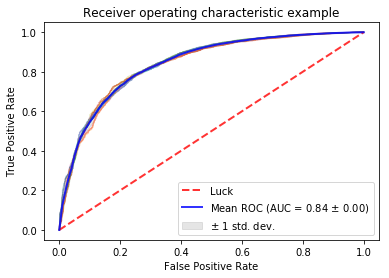

0.9364719

In [144]:
report_classification(df_train_pre,[pipe],cv_strategy,cv_strategy)

## Nested Cross Validation Modeling Trick

In [110]:
from sklearn.model_selection import GridSearchCV

In [159]:
model = XGBClassifier(verbose=True,random_state=2018)
frozen_param = {}
for k in model.get_params().keys():
    frozen_param['model__'+k] = [model.get_params()[k]]
pipe = Pipeline([
    ('prepro',na_mapper),
    ('feature_eng',feat_mapper),
    ('model',model)
])
cv_strategy = StratifiedKFold(n_splits=5)
nd_cv_res = cross_val_score(GridSearchCV(pipe,cv=3,scoring='roc_auc',verbose=True,param_grid=frozen_param)
                            ,scoring='roc_auc',cv=cv_strategy,X=df_train_pre,y=y,verbose=True)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   19.5s finished


In [160]:
nd_cv_res

array([0.57847342, 0.58551723, 0.57583795, 0.59491376, 0.5677934 ])

## Nested GridSearch

In [106]:
from sklearn.model_selection import GridSearchCV

In [246]:
params = {
    'model__min_child_weight': [1, 5, 10],
    'model__gamma': [0.5, 1, 1.5, 2, 5],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__max_depth': [3, 4, 5]
        }

In [ ]:
%%time
results = cross_val_score(
    GridSearchCV(pipe,
                 cv=StratifiedKFold(n_splits=2),
                 scoring='roc_auc',
                 param_grid=params,
                 verbose=True
                ), 
    X=df_train.copy(),
    y=y,                 
    scoring='roc_auc',
    verbose=True
)

Fitting 2 folds for each of 405 candidates, totalling 810 fits


## Submission